In [1]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import math
import time

#### RGB TO HSV

In [2]:
@cuda.jit
def RGB2HSV(rgb_in, h_out, s_out, v_out):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx < rgb_in.shape[1] and tidy < rgb_in.shape[0]:
        # Preparation
        # GATHER: gather value into 3 arrays
        ## Scale R, G, B to [0..255] to [0..1]
        r = rgb_in[tidy, tidx, 0] / 255.0
        g = rgb_in[tidy, tidx, 1] / 255.0
        b = rgb_in[tidy, tidx, 2] / 255.0
        ## Find max and min among R, G, B ∈[0..1]
        cmax = max(r, max(g, b))
        cmin = min(r, min(g, b))
        ## ∆ = max−min
        diff = cmax - cmin
        
        # Calculate Hue
        if diff == 0: h = 0
        if cmax == r: h = (60 * ((g - b) / diff) % 6) 
        if cmax == g: h = (60 * ((b - r) / diff + 2))
        if cmax == b: h = (60 * ((r - g) / diff + 4))
        # Calculate Saturation
        s = 0 if cmax == 0 else (diff / cmax)
        # Calculate Value
        v = cmax
        
        # SCATTER: Write results to separate arrays
        h_out[tidy, tidx] = h
        s_out[tidy, tidx] = s
        v_out[tidy, tidx] = v


def convert_rgb_to_hsv(rgb_image):
    # Create output arrays
    height= rgb_image.shape[0]
    width = rgb_image.shape[1]
    h_out = np.zeros((height, width), dtype=np.float32)
    s_out = np.zeros((height, width), dtype=np.float32)
    v_out = np.zeros((height, width), dtype=np.float32)
    # CPU to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h_out)
    d_s = cuda.to_device(s_out)
    d_v = cuda.to_device(v_out)
    # CPU set up grid and block dimensions
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    # GPU launch kernel
    RGB2HSV[grid_dim, block_dim](d_rgb, d_h, d_s, d_v)
    # GPU to CPU
    h_out = d_h.copy_to_host()
    s_out = d_s.copy_to_host()
    v_out = d_v.copy_to_host()
    
    return h_out, s_out, v_out

#### KUWAHARA FILTER WITHOUT SHARED MEMORY

Each thread directly accesses global memory repeatedly when computing each quadrant

Multiple redundant reads occur since neighboring threads need the same pixel values

High latency (400-800 cycles) for each global memory access

More memory bandwidth used due to redundant reads

Execution time with shared memory: 0.442 seconds


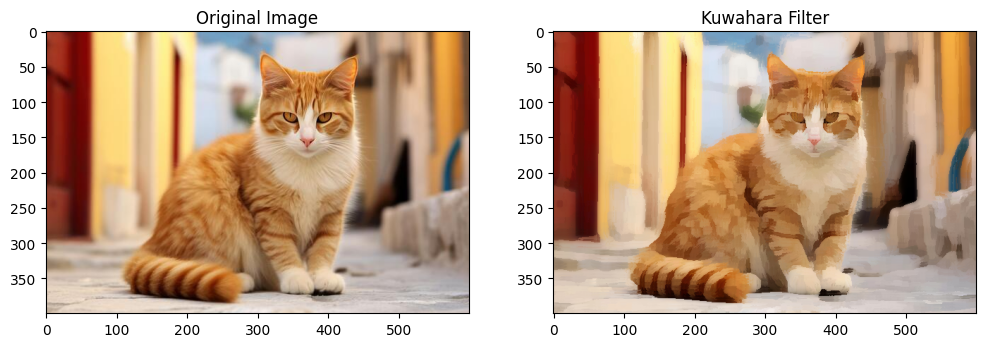

In [3]:
@cuda.jit
def kuwahara_filter(rgb_in, h_in, s_in, v_in, rgb_out, window_size):
    """
    Kernel take input: FOR EACH pixel 
    + HSV, RGB value
    + Window size as a constant parameter
    Return: new RGB of that pixel
    Use local memory: register and array, private for each threads
    """
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y    
    height, width = rgb_in.shape[0], rgb_in.shape[1]
    if tidx >= width or tidy >= height:
        return
    
    # Operator
    min_std = 1e10  # Very large
    chosen_quadrant = 0
    means_rgb = cuda.local.array((4, 3), dtype=np.float32) # quadrant, mean R, mean G, mean B # Optimization
    for i in range(4):
        for j in range(3):
            means_rgb[i][j] = 0.0
    for quadrant in range(4):
        sum_v = 0.0
        sum_v_squared = 0.0
        sum_rgb = cuda.local.array(3, dtype=np.float32) # Optimization
        sum_rgb[0] = 0.0
        sum_rgb[1] = 0.0
        sum_rgb[2] = 0.0
        count = 0
        
        # Define 4 quadrant: W_0,W_1,W_2,W_3 
        # For each pixel (i,j), window size w, neighhborhood square window: 2*w + 1
        # W_0 : x = [i - w, i], y = [j - w, j] # Top left
        # W_1 : x = [i, i + w], y = [j - w, j] # Top right
	    # W_2 : x = [i - w, i], y = [j, j + w] # Botom left
	    # W_3 : x = [i, i + w], y = [j, j + w] # Bottom right
        if quadrant == 0:   
            start_x, end_x = max(tidx - window_size, 0), tidx + 1
            start_y, end_y = max(tidy - window_size, 0), tidy + 1
        if quadrant == 1: 
            start_x, end_x = tidx, min(tidx + window_size + 1, width)
            start_y, end_y = max(tidy - window_size, 0), tidy + 1
        if quadrant == 2:  
            start_x, end_x = max(tidx - window_size, 0), tidx + 1
            start_y, end_y = tidy, min(tidy + window_size + 1, height)
        if quadrant == 3:               
            start_x, end_x = tidx, min(tidx + window_size + 1, width)
            start_y, end_y = tidy, min(tidy + window_size + 1, height)
        
        # Read from global
        for y in range(start_y, end_y):
            for x in range(start_x, end_x):
                # Use V in HSV for standard deviation
                v_val = v_in[y, x]
                sum_v += v_val
                sum_v_squared += v_val * v_val
                # Use RGB mean
                sum_rgb[0] += rgb_in[y, x, 0]
                sum_rgb[1] += rgb_in[y, x, 1]
                sum_rgb[2] += rgb_in[y, x, 2]
                count += 1
        
        mean_v = sum_v / count
        variance = (sum_v_squared / count) - (mean_v * mean_v)
        std_dev = math.sqrt(max(variance, 0.0))

        means_rgb[quadrant][0] = sum_rgb[0] / count
        means_rgb[quadrant][1] = sum_rgb[1] / count
        means_rgb[quadrant][2] = sum_rgb[2] / count
            
        # Use mean RGB value of quadrant with lowest standard deviation
        if std_dev < min_std:
            min_std = std_dev
            chosen_quadrant = quadrant
    
    # Replace pixel RGB with mean RGB of quadrant with lowest standard deviation
    rgb_out[tidy, tidx, 0] = means_rgb[chosen_quadrant][0] #gather
    rgb_out[tidy, tidx, 1] = means_rgb[chosen_quadrant][1]
    rgb_out[tidy, tidx, 2] = means_rgb[chosen_quadrant][2]

def apply_kuwahara_filter_no_share(rgb_image, window_size=3):
    h, s, v = convert_rgb_to_hsv(rgb_image)
    
    # Prepare memory
    height, width = rgb_image.shape[0], rgb_image.shape[1]
    output = np.zeros_like(rgb_image)
    
    # CPU to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h)
    d_s = cuda.to_device(s)
    d_v = cuda.to_device(v)
    d_output = cuda.to_device(output)
    
    # CPU ask GPU
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    
    # GPU processing
    kuwahara_filter[grid_dim, block_dim](d_rgb, d_h, d_s, d_v, d_output, window_size)
    
    # GPU to CPU
    output = d_output.copy_to_host()
    
    return output

# Usage 
def kuwahara_usage_no_share(window_size=4):
    image = plt.imread("image1.jpg")
    start = time.time()
    filtered_image = apply_kuwahara_filter_no_share(image, window_size)
    end = time.time()
    print(f"Execution time with shared memory: {end - start:.3f} seconds")
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(filtered_image)
    plt.title('Kuwahara Filter')
    plt.show()

kuwahara_usage_no_share(4)

#### KUWAHARA FILTER WITH SHARED MEMORY

Each thread loads data into shared memory once at the start

Subsequent accesses use shared memory with much lower latency (1x vs 100x of global memory)

Reduced global memory bandwidth usage

More efficient memory coalescing due to organized data layout

Execution time with shared memory: 0.353 seconds


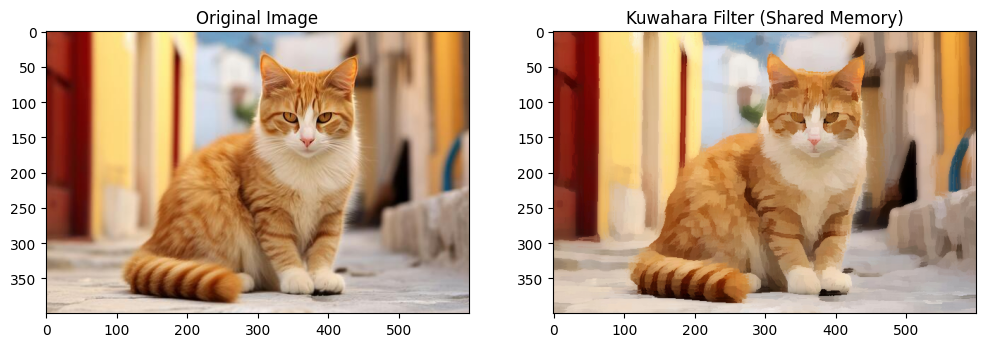

In [20]:
@cuda.jit
def kuwahara_filter_shared(rgb_in, h_in, s_in, v_in, rgb_out, window_size):
    """
    Kernel take input: FOR EACH pixel 
    + HSV, RGB value
    + Window size as a constant parameter
    Return: new RGB of that pixel
    Use shared memory
    """
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    block_width = cuda.blockDim.x
    block_height = cuda.blockDim.y

    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y   

    # if tidx >= width or tidy >= height:
    #     return

    height, width = rgb_in.shape[0], rgb_in.shape[1]

    shared_dim = block_width + 2 * window_size  # For each thread/pixel we need the neighborhood, so TILE_DIM = BLOCK_SIZE + 2 * window_size
    
    # Shared memory
    check = 48
    shared_rgb = cuda.shared.array(shape=(check, check, 3), dtype=np.float32)
    shared_v = cuda.shared.array(shape=(check, check), dtype=np.float32)

    # FOR EACH PIXEL: Load data into shared memory
    for dy in range(0, shared_dim, block_height):
        for dx in range(0, shared_dim, block_width):
            shared_y = ty + dy
            shared_x = tx + dx
            global_y = tidy - window_size + dy
            global_x = tidx - window_size + dx

            if (global_y >= 0 and global_y < height and
                global_x >= 0 and global_x < width):
                shared_rgb[shared_y, shared_x, 0] = rgb_in[global_y, global_x, 0]  # R
                shared_rgb[shared_y, shared_x, 1] = rgb_in[global_y, global_x, 1]  # G
                shared_rgb[shared_y, shared_x, 2] = rgb_in[global_y, global_x, 2]  # B
                shared_v[shared_y, shared_x] = v_in[global_y, global_x]
            else:
                shared_rgb[shared_y, shared_x, 0] = 0.0
                shared_rgb[shared_y, shared_x, 1] = 0.0
                shared_rgb[shared_y, shared_x, 2] = 0.0
                shared_v[shared_y, shared_x] = 0.0

    cuda.syncthreads()

    if tidx < width and tidy < height:
        means = cuda.local.array((4, 3), dtype=np.float32) 
        variances = cuda.local.array(4, dtype=np.float32)

        for quadrant in range(4):
            sum_R = 0.0
            sum_G = 0.0
            sum_B = 0.0
            sum_v = 0.0
            sum_v_squared = 0.0
            count = 0

            shared_x = tx + window_size
            shared_y = ty + window_size

            if quadrant == 0:  
                x_start, x_end = shared_x - window_size, shared_x + 1
                y_start, y_end = shared_y - window_size, shared_y + 1
            if quadrant == 1:
                x_start, x_end = shared_x, shared_x + window_size + 1
                y_start, y_end = shared_y - window_size, shared_y + 1
            if quadrant == 2:
                x_start, x_end = shared_x - window_size, shared_x + 1
                y_start, y_end = shared_y, shared_y + window_size + 1
            if quadrant == 3:
                x_start, x_end = shared_x, shared_x + window_size + 1
                y_start, y_end = shared_y, shared_y + window_size + 1

            # Read from shared
            for yi in range(y_start, y_end):
                for xi in range(x_start, x_end):
                    count += 1
                    r = shared_rgb[yi, xi, 0]
                    g = shared_rgb[yi, xi, 1]
                    b = shared_rgb[yi, xi, 2]
                    v = shared_v[yi, xi]

                    sum_R += r
                    sum_G += g
                    sum_B += b
                    sum_v += v
                    sum_v_squared += v * v

            means[quadrant, 0] = sum_R / count
            means[quadrant, 1] = sum_G / count
            means[quadrant, 2] = sum_B / count
            mean_v = sum_v / count
            variances[quadrant] = (sum_v_squared / count) - (mean_v * mean_v)

        min_var = variances[0]
        min_idx = 0
        for quadrant in range(1, 4):
            if variances[quadrant] < min_var:
                min_var = variances[quadrant]
                min_idx = quadrant

        rgb_out[tidy, tidx, 0] = means[min_idx, 0]
        rgb_out[tidy, tidx, 1] = means[min_idx, 1]
        rgb_out[tidy, tidx, 2] = means[min_idx, 2]


def apply_kuwahara_filter_shared(rgb_image, window_size=4):
    h, s, v = convert_rgb_to_hsv(rgb_image)
    
    # Prepare memory
    height, width = rgb_image.shape[0], rgb_image.shape[1]
    output = np.zeros_like(rgb_image)
    
    # CPU to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h)
    d_s = cuda.to_device(s)
    d_v = cuda.to_device(v)
    d_output = cuda.to_device(output)
    
    # Configuration: CPU asks GPU
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    
    # GPU processing
    kuwahara_filter_shared[grid_dim, block_dim](d_rgb, d_h, d_s, d_v, d_output, window_size)
    
    # GPU to CPU
    output = d_output.copy_to_host()
    
    return output

# Usage 
def kuwahara_usage_shared(window_size=4):
    image = plt.imread("image1.jpg")
    start = time.time()
    filtered_image = apply_kuwahara_filter_shared(image, window_size)
    end = time.time()
    print(f"Execution time with shared memory: {end - start:.3f} seconds")
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(filtered_image)
    plt.title('Kuwahara Filter (Shared Memory)')
    plt.show()

kuwahara_usage_shared(4)

#### BENCHMARKING

In [7]:
def benchmark_kuwahara():
    image = plt.imread("image1.jpg")
    height, width = image.shape[:2]

    print("Input image shape:", image.shape)
    
    # Without shared memory
    start = time.time()
    filtered_no_shared = apply_kuwahara_filter_no_share(image, 4)
    time_no_shared = time.time() - start
    
    # With shared memory
    start = time.time()
    filtered_shared = apply_kuwahara_filter_shared(image, 4)
    time_shared = time.time() - start
    
    speedup = time_no_shared / time_shared
    
    print(f"No shared memory: {time_no_shared:.3f} seconds")
    print(f"With shared memory: {time_shared:.3f} seconds")
    print(f"Speedup: {speedup:.2f}x")

benchmark_kuwahara()

Input image shape: (400, 600, 3)
No shared memory: 0.010 seconds
With shared memory: 0.006 seconds
Speedup: 1.79x


Block size (8, 8): 0.016 seconds
Block size (16, 16): 0.007 seconds


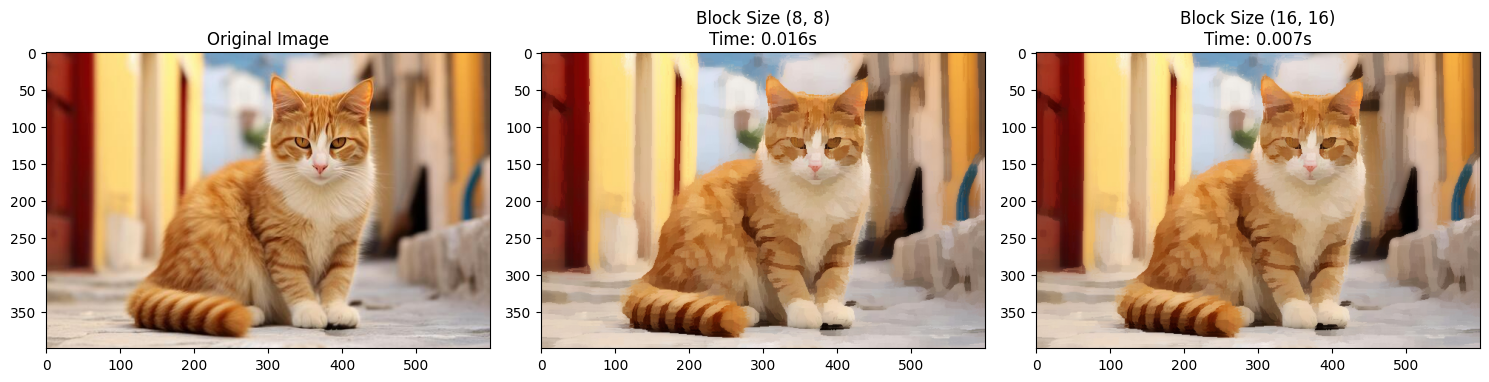


Performance Summary:
----------------------------------------
Block Size (8, 8): 0.016 seconds
Block Size (16, 16): 0.007 seconds


In [22]:
def apply_kuwahara_filter(rgb_image, block_size=(16,16), window_size=4):
    """
    Apply Kuwahara filter with configurable block size
    """
    # Convert to HSV
    h, s, v = convert_rgb_to_hsv(rgb_image)
    
    # Prepare memory
    height, width = rgb_image.shape[0], rgb_image.shape[1]
    output = np.zeros_like(rgb_image)
    
    # Move data to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h)
    d_s = cuda.to_device(s)
    d_v = cuda.to_device(v)
    d_output = cuda.to_device(output)
    
    # Configure grid dimensions based on block_size
    block_dim = block_size
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    
    # Run kernel
    kuwahara_filter_shared[grid_dim, block_dim](
        d_rgb, d_h, d_s, d_v, d_output, window_size
    )
    
    # Copy result back to CPU
    output = d_output.copy_to_host()
    
    return output

def benchmark_block_sizes(image, block_sizes=[(8,8), (16,16)], window_size=4):
    """
    Benchmark different block sizes and return execution times
    """
    results = {}
    
    for block_size in block_sizes:
        start = time.time()
        filtered_image = apply_kuwahara_filter(image, block_size, window_size)
        end = time.time()
        
        execution_time = end - start
        results[block_size] = {
            'time': execution_time,
            'output': filtered_image
        }
        print(f"Block size {block_size}: {execution_time:.3f} seconds")
    
    return results

def test_kuwahara_configurations():
    # Load test image
    image = plt.imread("image1.jpg")
    
    # Test different block sizes
    block_sizes = [(8,8), (16,16)]
    results = benchmark_block_sizes(image, block_sizes)
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    
    # Plot results for each block size
    for idx, block_size in enumerate(block_sizes, start=2):
        plt.subplot(2, 3, idx)
        plt.imshow(results[block_size]['output'])
        plt.title(f'Block Size {block_size}\nTime: {results[block_size]["time"]:.3f}s')
    
    plt.tight_layout()
    plt.show()
    
    # Print performance summary
    print("\nPerformance Summary:")
    print("-" * 40)
    for block_size in block_sizes:
        print(f"Block Size {block_size}: {results[block_size]['time']:.3f} seconds")

# Run the test
test_kuwahara_configurations()

#### OPTIMIZATION

Shared Memory Tiling:

Memory Coalescing:

Bank Conflict Mitigation:

Reduce Register Pressure:
